In [1]:
%cd /Midgard/home/amirme/an_explanation_model

/Midgard/home/amirme/an_explanation_model


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial

from source.project_manager import (
    load_experiment_inconsistency,
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from commands.experiment_6_0 import (
    save_metadata_dir,
    dataset_dir,
    input_shape,
    save_output_dir,
)
os.makedirs(save_output_dir, exist_ok=True)
from source.data_manager import (
    preprocess_masks,
    plot_masks,
    minmax_normalize,
    sum_channels,
    symmetric_minmax_normalize,
    single_query_imagenet,
    save_axis,
)
from source.labels import IMAGENET_LABELS

imshow_args = {"cmap": "viridis", "vmin": 0, "vmax": 1}

query_imagenet = partial(
    single_query_imagenet, dataset_dir=dataset_dir, input_shape=input_shape
)

2023-10-29 11:15:26.985033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 11:15:28.179683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/Midgard/home/amirme/miniconda3/envs/xmodel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
project_metadata = load_experiment_metadata(save_metadata_dir)
print(project_metadata.columns)
project_metadata = project_metadata.set_index(
    [
        "stream_name",
        "stream_statistic",
        "image_index",
        "baseline_mask_type",
        "alpha_mask_value",
    ]
).sort_index()
print(project_metadata.shape)

Index(['time_to_compute', 'batch_index', 'monitored_statistic_change',
       'path_prefix', 'data_path', 'stream_name', 'stream_statistic',
       'alpha_mask_type', 'alpha_mask_value', 'baseline_mask_type',
       'projection_type', 'projection_distribution', 'projection_top_k',
       'projection_index', 'label', 'architecture', 'method', 'output_layer',
       'dataset', 'image_index', 'input_shape', 'num_classes', 'seed',
       'batch_size', 'max_batches', 'min_change', 'metadata_file_path'],
      dtype='object')
(2100, 22)


In [4]:
vc = project_metadata.index.value_counts()
print(vc)
print(len(vc))
image_indices = project_metadata.index.get_level_values("image_index").unique()

stream_name        stream_statistic  image_index  baseline_mask_type  alpha_mask_value
log_probs          meanx             1            gaussian            0.0                 1
vanilla_grad_mask  meanx2            2            gaussian            0.4                 1
                                                                      0.2                 1
                                                                      0.1                 1
                                                                      0.0                 1
                                                                                         ..
log_probs          meanx             100          gaussian            0.1                 1
                                                                      0.0                 1
                                     99           gaussian            0.6                 1
                                                                      0.5            

In [5]:
for name in project_metadata.index.names:
    print(name,"=",project_metadata.index.get_level_values(name).value_counts().to_dict())

stream_name = {'log_probs': 700, 'results_at_projection': 700, 'vanilla_grad_mask': 700}
stream_statistic = {'meanx': 1400, 'meanx2': 700}
image_index = {1: 21, 64: 21, 74: 21, 73: 21, 72: 21, 71: 21, 70: 21, 69: 21, 68: 21, 67: 21, 66: 21, 65: 21, 63: 21, 2: 21, 62: 21, 61: 21, 60: 21, 59: 21, 58: 21, 57: 21, 56: 21, 55: 21, 54: 21, 53: 21, 75: 21, 76: 21, 77: 21, 78: 21, 99: 21, 98: 21, 97: 21, 96: 21, 95: 21, 94: 21, 93: 21, 92: 21, 91: 21, 90: 21, 89: 21, 88: 21, 87: 21, 86: 21, 85: 21, 84: 21, 83: 21, 82: 21, 81: 21, 80: 21, 79: 21, 52: 21, 51: 21, 50: 21, 25: 21, 23: 21, 22: 21, 21: 21, 20: 21, 19: 21, 18: 21, 17: 21, 16: 21, 15: 21, 14: 21, 13: 21, 12: 21, 11: 21, 10: 21, 9: 21, 8: 21, 7: 21, 6: 21, 5: 21, 4: 21, 3: 21, 24: 21, 26: 21, 49: 21, 27: 21, 48: 21, 47: 21, 46: 21, 45: 21, 44: 21, 43: 21, 42: 21, 41: 21, 40: 21, 39: 21, 38: 21, 37: 21, 36: 21, 35: 21, 34: 21, 33: 21, 32: 21, 31: 21, 30: 21, 29: 21, 28: 21, 100: 21}
baseline_mask_type = {'gaussian': 2100}
alpha_mask_val

In [6]:
inconsistency_data = load_experiment_inconsistency(save_metadata_dir,"inconsistency_cosine*.csv")
print(inconsistency_data.columns)

Index(['inconsistency', 'image_index', 'projection_index'], dtype='object')


In [7]:
top5 = inconsistency_data.sort_values("inconsistency", ascending=False).head(5)
top5

,inconsistency,image_index,projection_index
83,0.839711,84,767
15,0.805833,16,727
42,0.782268,43,104
54,0.775319,55,640
65,0.768415,66,896


In [8]:
bottom5 = inconsistency_data.sort_values("inconsistency", ascending=True).head(5)
bottom5

,inconsistency,image_index,projection_index
68,0.352156,69,21
96,0.364212,97,109
39,0.398366,40,979
69,0.415166,70,958
16,0.429712,17,847


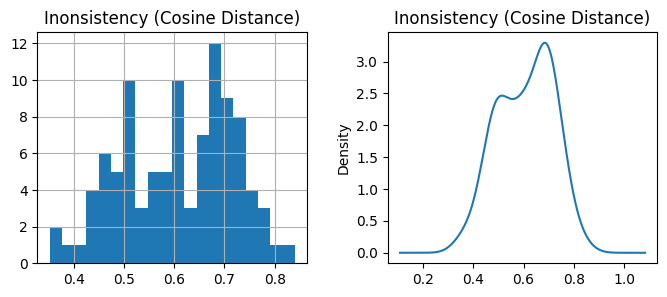

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
inconsistency_data.hist(column="inconsistency", bins=20,ax=axes[0])
inconsistency_data.plot.kde(y="inconsistency",ax=axes[1])
axes[0].set_title("Inonsistency (Cosine Distance)")
axes[1].set_title("Inonsistency (Cosine Distance)")
axes[1].get_legend().remove()
save_axis(["inconsistency hist","inconsistency kde"], fig, axes, save_output_dir)

2023-10-29 11:18:30.192174: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-29 11:18:30.192226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: gondor
2023-10-29 11:18:30.192234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: gondor
2023-10-29 11:18:30.192319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.89.2
2023-10-29 11:18:30.192343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.89.2
2023-10-29 11:18:30.192349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.89.2
2023-10-29 11:18:30.850635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (

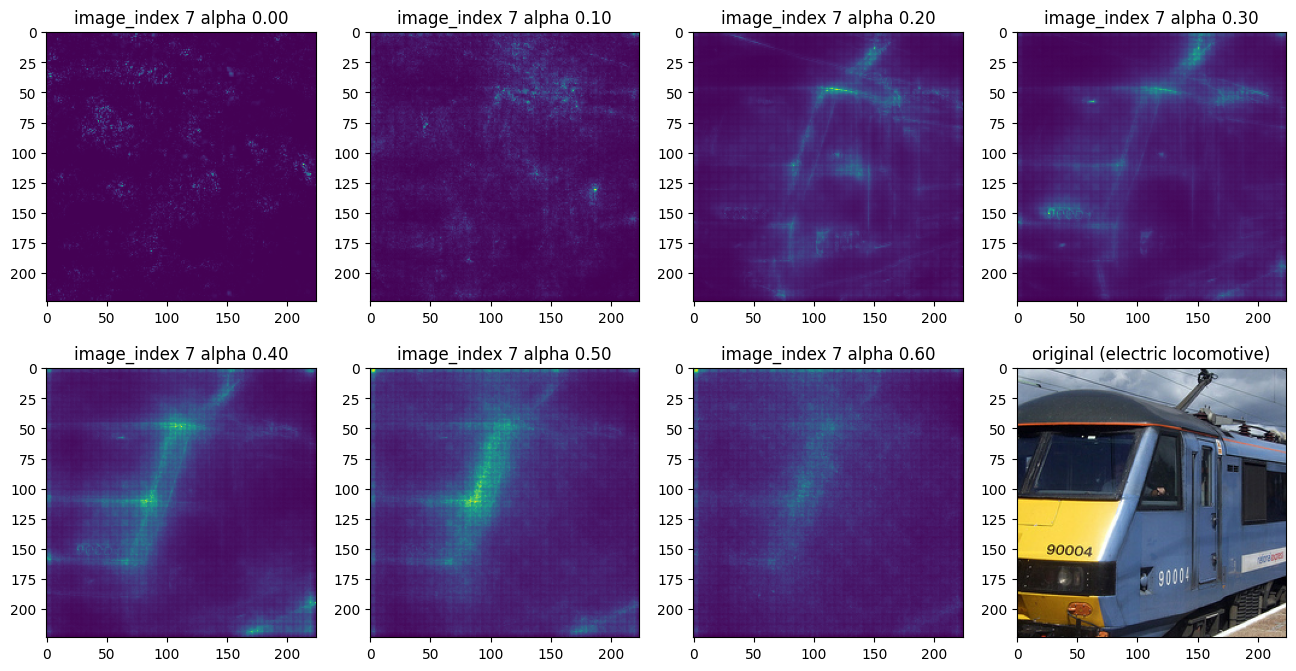

In [14]:
image_index = 7
original_image, label, image_path = query_imagenet(image_index=image_index)
temp = project_metadata.loc[("vanilla_grad_mask", "meanx2", image_index, "gaussian")]
temp_masks = temp["data_path"].apply(np.load)
titles = temp.index.to_series().apply(lambda x: f"image_index {image_index} alpha {x:.2f}")
temp_masks = preprocess_masks(temp_masks, preprocesses=[sum_channels, minmax_normalize])
fig, axes = plot_masks(temp_masks, titles=titles, imshow_args=imshow_args, ncols=4)
axes[1, 3].imshow(original_image[0].squeeze(), **imshow_args)
axes[1, 3].set_title(f"original ({IMAGENET_LABELS[label]})")
titles["original"] = f"image_index {image_index} original"
save_axis(titles, fig, axes, save_output_dir)

2023-10-28 20:03:50.481703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [50000]
	 [[{{node Placeholder/_1}}]]
2023-10-28 20:03:50.482204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [50000]
	 [[{{node Placeholder/_1}}]]


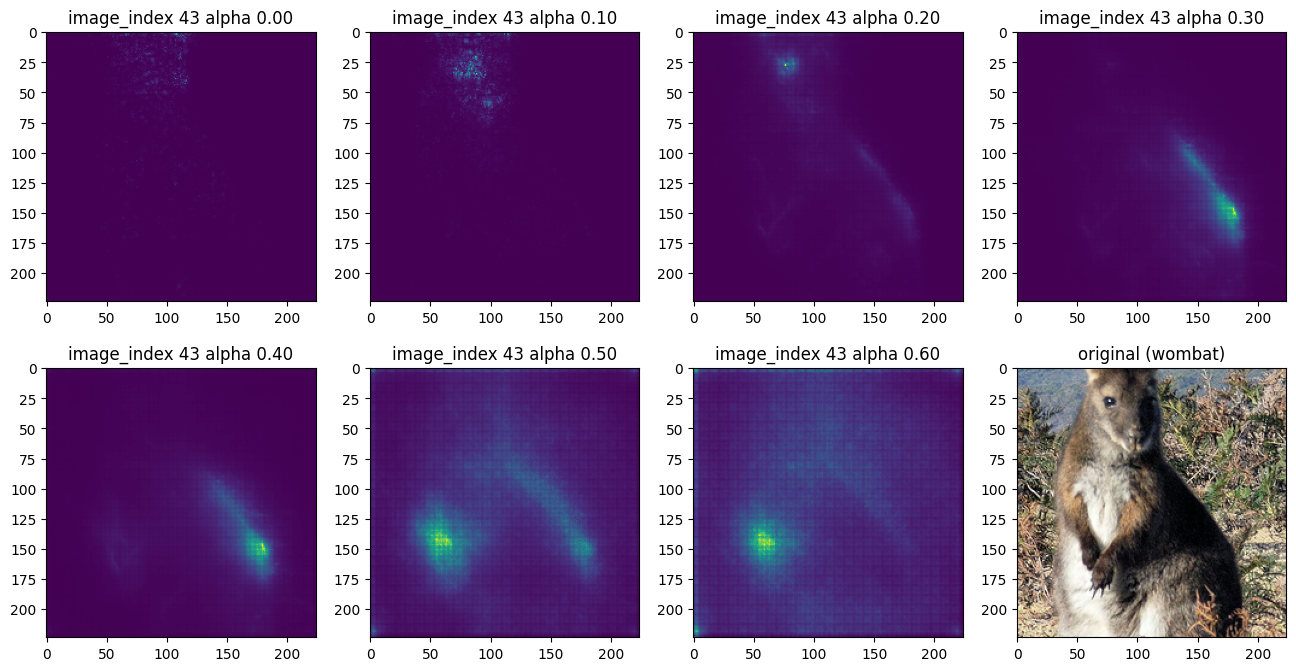

In [14]:
image_index = 43
original_image, label, image_path = query_imagenet(image_index=image_index)
temp = project_metadata.loc[("vanilla_grad_mask", "meanx2", image_index, "gaussian")]
temp_masks = temp["data_path"].apply(np.load)
titles = temp.index.to_series().apply(lambda x: f"image_index {image_index} alpha {x:.2f}")
temp_masks = preprocess_masks(temp_masks, preprocesses=[sum_channels, minmax_normalize])
fig, axes = plot_masks(temp_masks, titles=titles, imshow_args=imshow_args, ncols=4)
axes[1, 3].imshow(original_image[0].squeeze(), **imshow_args)
axes[1, 3].set_title(f"original ({IMAGENET_LABELS[label]})")
titles["original"] = f"image_index {image_index} original"
save_axis(titles, fig, axes, save_output_dir)

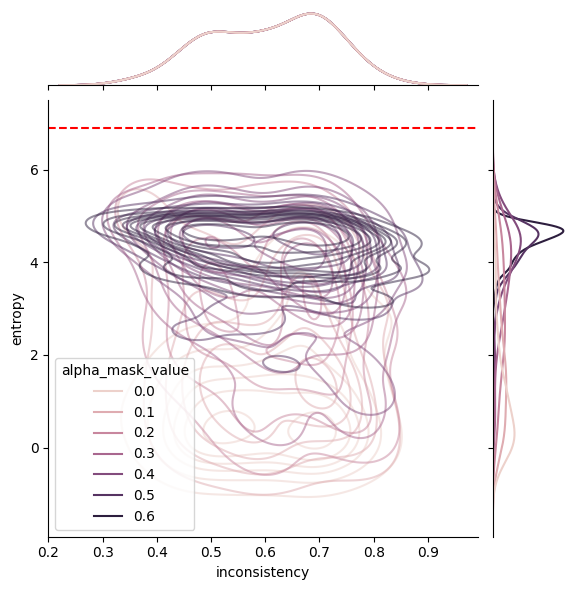

In [49]:
inconsistency_data = inconsistency_data.sort_values("image_index")
project_metadata = project_metadata.sort_index()
prediction_data = project_metadata.loc[("log_probs", "meanx", slice(None), "gaussian"),"data_path"].apply(np.load)
def entropy(log_probs):
    return -np.sum(np.exp(log_probs) * log_probs)
prediction_data = prediction_data.droplevel(["stream_name","stream_statistic","baseline_mask_type"])
entropy_data = prediction_data.apply(lambda log_probs: entropy(log_probs))
entropy_data = entropy_data.swaplevel(0,1).sort_index()
entropy_data = entropy_data.reset_index()
temp = inconsistency_data.drop(columns=["projection_index"])
temp = pd.merge(entropy_data,temp,on="image_index")
temp.rename(columns={"data_path":"entropy"},inplace=True)
random_baseline_entropy = -np.log(1/1000)
sns.jointplot(
    x="inconsistency",
    y="entropy",
    hue="alpha_mask_value",
    data=temp,
    kind="kde",
    alpha=0.5,
)
plt.axhline(random_baseline_entropy, color="red", linestyle="--")
plt.show()

In [50]:
preds = project_metadata.loc[("log_probs","meanx",slice(None),"gaussian",0.0),"data_path"]
labels = project_metadata.loc[("log_probs","meanx",slice(None),"gaussian",0.0),"label"]
preds = preds.apply(np.load).apply(np.argmax)
preds.name = "preds"
preds = preds == labels
preds = preds.droplevel(["stream_name","stream_statistic","baseline_mask_type","alpha_mask_value"])

temp_0 = temp[temp["alpha_mask_value"] == 0.0]
temp_0 = temp_0.set_index("image_index")
temp_0["is_correct"] = preds
temp_0 = temp_0.drop("alpha_mask_value",axis=1)

<Axes: xlabel='inconsistency', ylabel='entropy'>

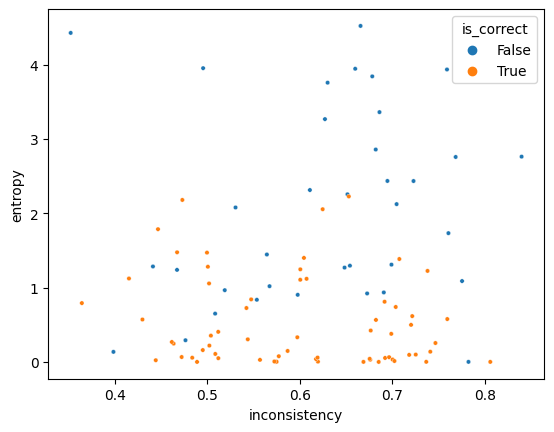

In [57]:
# X@F is the random variable X at frequency F
# entropy@0.0 vs inconsistency@avg
sns.scatterplot(
    x="inconsistency",
    y="entropy",
    hue="is_correct",
    data=temp_0,
    s=10,
)

<Axes: xlabel='inconsistency', ylabel='entropy'>

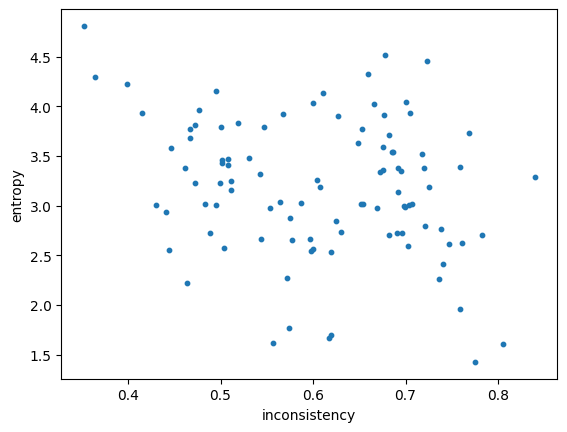

In [55]:
# X@F is the random variable X at frequency F
# entropy@avg vs inconsistency@avg
avg_groups = temp.groupby("image_index").mean()
avg_groups

avg_groups.plot.scatter(
    x="inconsistency",
    y="entropy",
    s=10,
)